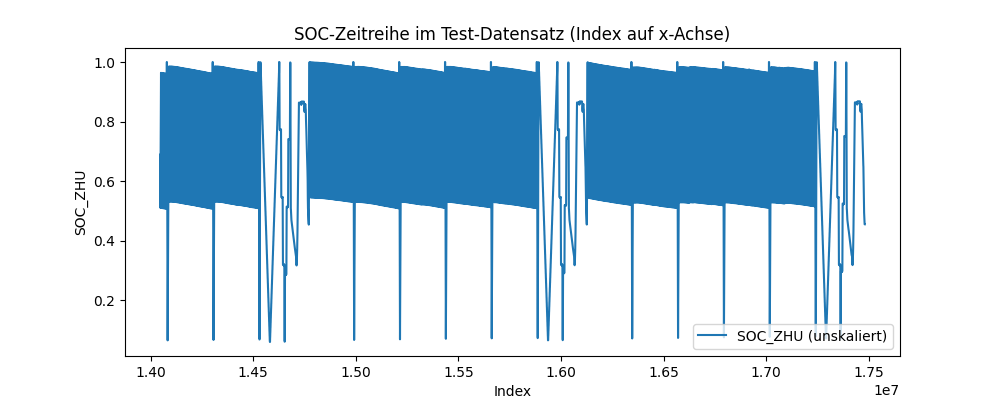

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_cell_data(data_dir: Path):
    dataframes = {}
    folder = data_dir / "MGFarm_18650_C01"
    if folder.exists() and folder.is_dir():
        df_path = folder / 'df.parquet'
        if df_path.exists():
            df = pd.read_parquet(df_path)
            dataframes["C01"] = df
        else:
            print(f"Warning: No df.parquet found in {folder.name}")
    else:
        print("Warning: Folder MGFarm_18650_C01 not found")
    return dataframes

def prepare_test_data():
    data_dir = Path("/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes")
    cell_data = load_cell_data(data_dir)
    cell_name = sorted(cell_data.keys())[0]
    df_full = cell_data[cell_name]

    df_small = df_full.copy()
    len_small = len(df_small)
    train_end = int(len_small * 0.4)
    val_end   = int(len_small * 0.8)
    df_test   = df_small.iloc[val_end:].copy()

    # Skalierung (Voltage, Current) vorbereiten (falls später nötig)
    features_to_scale = ['Voltage[V]', 'Current[A]']
    scaler = StandardScaler()
    df_train = df_small.iloc[:train_end]
    scaler.fit(df_train[features_to_scale])
    df_test_scaled = df_test.copy()
    df_test_scaled[features_to_scale] = scaler.transform(df_test_scaled[features_to_scale])

    seq_length = 60
    return df_test, df_test_scaled, seq_length

def main():
    df_test, df_test_scaled, seq_length = prepare_test_data()
    plt.figure(figsize=(10,4))
    plt.plot(df_test.index, df_test["SOC_ZHU"], label="SOC_ZHU (unskaliert)")
    plt.title("SOC-Zeitreihe im Test-Datensatz (Index auf x-Achse)")
    plt.xlabel("Index")
    plt.ylabel("SOC_ZHU")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

/tmp/ipykernel_446295/1978832011.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Loaded model from: /home/florianr/MG_Farm/6_Scripts/BMS/Python/BMS_SOC_LSTM_1.1.3/models/best_lstm_soc_model.pth


NameError: name '__file__' is not defined

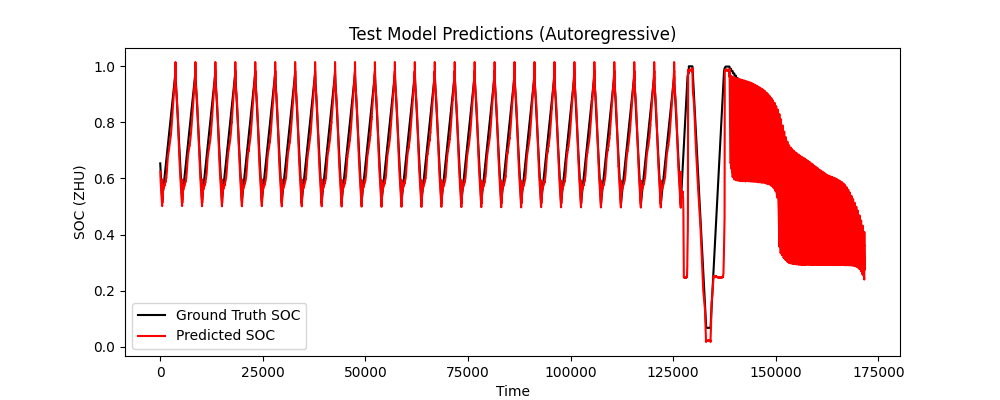

In [9]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset
import torch.nn as nn
%matplotlib widget

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###############################################################################
# 1) Daten laden und vorbereiten
###############################################################################
def load_cell_data(data_dir: Path):
    """
    Lädt df.parquet aus /MGFarm_18650_C01 und gibt ein dict {cell_name: dataframe} zurück.
    """
    dataframes = {}
    folder = data_dir / "MGFarm_18650_C01"
    if folder.exists() and folder.is_dir():
        df_path = folder / 'df.parquet'
        if df_path.exists():
            df = pd.read_parquet(df_path)
            dataframes["C01"] = df
        else:
            print(f"Warning: No df.parquet found in {folder.name}")
    else:
        print("Warning: Folder MGFarm_18650_C01 not found")
    return dataframes

def prepare_test_data():
    """
    Lädt die Daten, splittet in Train/Val/Test, skaliert die relevanten Spalten und gibt den
    unskalierten und skalierten Test-Df zurück + seq_length.
    """
    data_dir = Path("/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes")
    cell_data = load_cell_data(data_dir)
    cell_name = sorted(cell_data.keys())[0]
    df_full = cell_data[cell_name]

    # ...existing code for selecting smaller portion, time-based splits...
    df_small = df_full.copy()
    len_small = len(df_small)
    train_end = int(len_small * 0.4)
    val_end   = int(len_small * 0.8)
    df_test   = df_small.iloc[val_end:].copy()

    # Skalierung (Voltage, Current)
    features_to_scale = ['Voltage[V]', 'Current[A]']
    scaler = StandardScaler()
    df_train   = df_small.iloc[:train_end]
    scaler.fit(df_train[features_to_scale])
    df_test_scaled = df_test.copy()
    df_test_scaled[features_to_scale] = scaler.transform(df_test_scaled[features_to_scale])

    # seq_length wie im Training annehmen
    seq_length = 60
    return df_test, df_test_scaled, seq_length

###############################################################################
# 2) Modell definieren (muss exakt wie im Training sein)
###############################################################################
class LSTMSOCModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=2, batch_first=True):
        super().__init__()
        # ...existing code...
        from pytorch_forecasting.models.nn.rnn import LSTM as ForecastingLSTM
        self.lstm = ForecastingLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # ...existing code...
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        soc_pred = self.fc(last_out)
        return soc_pred.squeeze(-1)

###############################################################################
# 3) Autoregressive Vorhersage (identisch wie im Training)
###############################################################################
def predict_autoregressive(model, df, seq_len=60):
    # ...existing code...
    model.eval()
    data_array = df[["Voltage[V]", "Current[A]", "SOC_ZHU"]].values.copy()
    preds = np.full(len(data_array), np.nan)
    with torch.no_grad():
        for i in range(seq_len, len(data_array)):
            input_seq = data_array[i - seq_len : i]
            x_t = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
            pred_soc = model(x_t).item()
            preds[i] = pred_soc
            data_array[i, 2] = pred_soc
    return preds

###############################################################################
# 4) Test-Funktion: Lädt Modell aus festem Pfad, wendet auf (ggf. geslictes) Testset an
###############################################################################
def test_model(index_offset=0, size_percent=10.0):
    """
    Lädt das beste Modell, holt den Test-Datensatz, skaliert ihn wie im Training,
    verschiebt den Index um index_offset und nimmt size_percent Prozent der Testdaten.
    """
    df_test, df_test_scaled, seq_length = prepare_test_data()

    total_len = len(df_test_scaled)
    start_idx = max(0, index_offset)
    segment_len = int(total_len * (size_percent / 100.0))
    end_idx = min(start_idx + segment_len, total_len)

    # Modell laden
    model_path = Path("/home/florianr/MG_Farm/6_Scripts/BMS/Python/"
                      "BMS_SOC_LSTM_1.1.3/models/best_lstm_soc_model.pth")
    model = LSTMSOCModel()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Loaded model from: {model_path}")

    # Vorhersage
    df_test_segment = df_test_scaled.iloc[start_idx:end_idx]
    preds = predict_autoregressive(model, df_test_segment, seq_len=seq_length)

    # Unskalierter Ground Truth
    df_test_unscaled_segment = df_test.iloc[start_idx:end_idx]
    gt_segment = df_test_unscaled_segment["SOC_ZHU"].values
    t_segment  = df_test_unscaled_segment.get("timestamp", range(len(df_test_unscaled_segment)))

    # Plotten
    plt.figure(figsize=(10,4))
    plt.plot(t_segment, gt_segment, label="Ground Truth SOC", color='k')
    plt.plot(t_segment, preds, label="Predicted SOC", color='r')
    plt.title("Test Model Predictions (Autoregressive)")
    plt.xlabel("Time")
    plt.ylabel("SOC (ZHU)")
    plt.legend()
    script_dir = Path(__file__).parent
    out_file = script_dir / "test_model_plot.png"
    plt.savefig(out_file)
    plt.close()
    print(f"Test plot saved to: {out_file}")

if __name__ == "__main__":
    # Beispiel-Aufruf (anpassbar):
    test_model(index_offset=350000, size_percent=5.0)


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###############################################################################
# 1) Daten laden und vorbereiten
###############################################################################
def load_cell_data(data_dir: Path):
    """
    Lädt df.parquet aus /MGFarm_18650_C01 und gibt ein dict {cell_name: dataframe} zurück.
    """
    dataframes = {}
    folder = data_dir / "MGFarm_18650_C01"
    if folder.exists() and folder.is_dir():
        df_path = folder / 'df.parquet'
        if df_path.exists():
            df = pd.read_parquet(df_path)
            dataframes["C01"] = df
        else:
            print(f"Warning: No df.parquet found in {folder.name}")
    else:
        print("Warning: Folder MGFarm_18650_C01 not found")
    return dataframes

def prepare_test_data():
    """
    Lädt die Daten, splittet in Train/Val/Test, skaliert die relevanten Spalten und gibt den
    unskalierten und skalierten Test-Df zurück + seq_length.
    """
    data_dir = Path("/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes")
    cell_data = load_cell_data(data_dir)
    cell_name = sorted(cell_data.keys())[0]
    df_full = cell_data[cell_name]

    # ...existing code for selecting smaller portion, time-based splits...
    df_small = df_full.copy()
    len_small = len(df_small)
    train_end = int(len_small * 0.4)
    val_end   = int(len_small * 0.8)
    df_test   = df_small.iloc[val_end:].copy()

    # Skalierung (Voltage, Current)
    features_to_scale = ['Voltage[V]', 'Current[A]']
    scaler = StandardScaler()
    df_train   = df_small.iloc[:train_end]
    scaler.fit(df_train[features_to_scale])
    df_test_scaled = df_test.copy()
    df_test_scaled[features_to_scale] = scaler.transform(df_test_scaled[features_to_scale])

    # seq_length wie im Training annehmen
    seq_length = 60
    return df_test, df_test_scaled, seq_length

###############################################################################
# 2) Modell definieren (muss exakt wie im Training sein)
###############################################################################
class LSTMSOCModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=2, batch_first=True):
        super().__init__()
        # ...existing code...
        from pytorch_forecasting.models.nn.rnn import LSTM as ForecastingLSTM
        self.lstm = ForecastingLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # ...existing code...
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        soc_pred = self.fc(last_out)
        return soc_pred.squeeze(-1)

###############################################################################
# 3) Autoregressive Vorhersage (identisch wie im Training)
###############################################################################
def predict_autoregressive(model, df, seq_len=60):
    # ...existing code...
    model.eval()
    data_array = df[["Voltage[V]", "Current[A]", "SOC_ZHU"]].values.copy()
    preds = np.full(len(data_array), np.nan)
    with torch.no_grad():
        for i in range(seq_len, len(data_array)):
            input_seq = data_array[i - seq_len : i]
            x_t = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
            pred_soc = model(x_t).item()
            preds[i] = pred_soc
            data_array[i, 2] = pred_soc
    return preds

###############################################################################
# 4) Test-Funktion: Lädt Modell aus festem Pfad, wendet auf (ggf. geslictes) Testset an
###############################################################################
def test_model(size_percent=10.0):
    """
    Loop over 10 offsets, each 5000 apart, to generate 10 test plots.
    """
    df_test, df_test_scaled, seq_length = prepare_test_data()
    total_len = len(df_test_scaled)

    # Load model
    model_path = Path("/home/florianr/MG_Farm/6_Scripts/BMS/Python/"
                      "BMS_SOC_LSTM_1.1.3/models/best_lstm_soc_model.pth")
    model = LSTMSOCModel()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Create "test" subfolder for saving plots
    script_dir = Path(__file__).parent
    out_folder = script_dir / "test"
    out_folder.mkdir(exist_ok=True)
    print(f"Loaded model from: {model_path}")

    for i in range(10):
        offset = 50000 + 350000 * i
        start_idx = max(0, offset)
        segment_len = int(total_len * (size_percent / 100.0))
        end_idx = min(start_idx + segment_len, total_len)

        df_test_segment = df_test_scaled.iloc[start_idx:end_idx]
        preds = predict_autoregressive(model, df_test_segment, seq_len=seq_length)

        df_test_unscaled_segment = df_test.iloc[start_idx:end_idx]
        gt_segment = df_test_unscaled_segment["SOC_ZHU"].values
        t_segment  = df_test_unscaled_segment.get("timestamp", range(len(df_test_unscaled_segment)))

        plt.figure(figsize=(10,4))
        plt.plot(t_segment, gt_segment, label="Ground Truth SOC", color='k')
        plt.plot(t_segment, preds, label="Predicted SOC", color='r')
        plt.title(f"Test Model Predictions (Offset={offset})")
        plt.xlabel("Time")
        plt.ylabel("SOC (ZHU)")
        plt.legend()

        out_file = out_folder / f"test_model_plot_{i}.png"
        plt.savefig(out_file)
        plt.close()
        print(f"Test plot {i} saved to: {out_file}")

if __name__ == "__main__":
    # Generate 10 test plots, each with 5,000 index offset steps.
    test_model(size_percent=10.0)


# Test mit Filter

/tmp/ipykernel_448501/4254131405.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


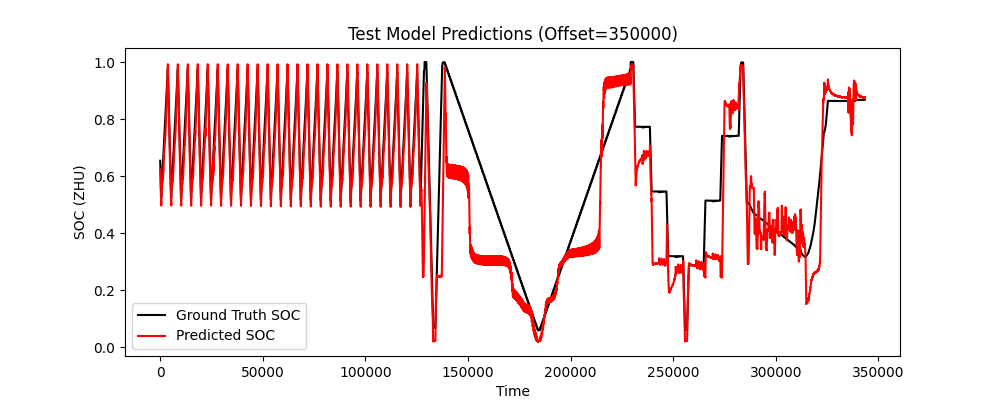

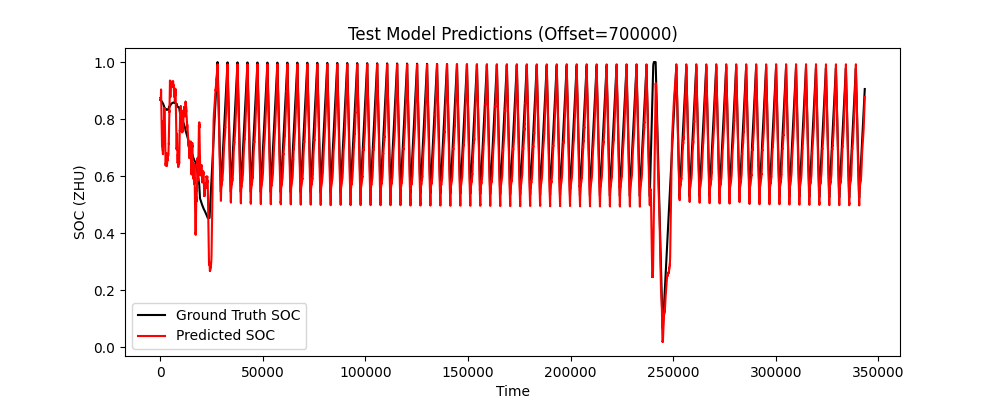

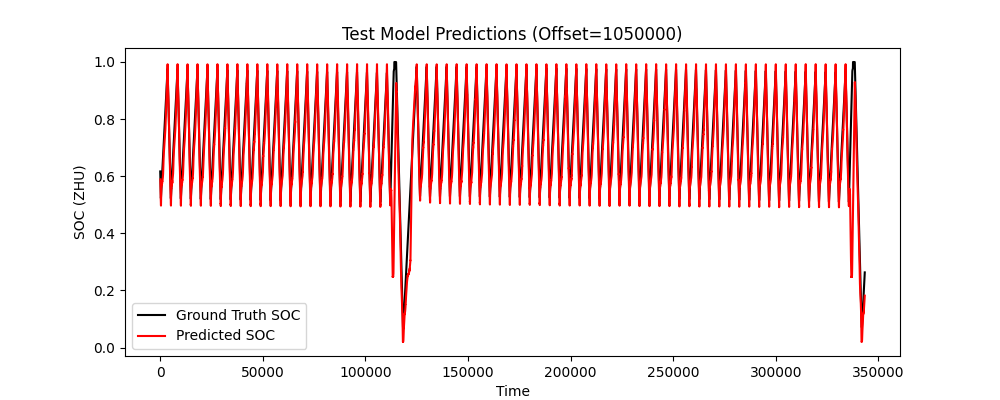

KeyboardInterrupt: 

In [5]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset
import torch.nn as nn
%matplotlib widget

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###############################################################################
# 1) Daten laden und vorbereiten
###############################################################################
def load_cell_data(data_dir: Path):
    """
    Lädt df.parquet aus /MGFarm_18650_C01 und gibt ein dict {cell_name: dataframe} zurück.
    """
    dataframes = {}
    folder = data_dir / "MGFarm_18650_C01"
    if folder.exists() and folder.is_dir():
        df_path = folder / 'df.parquet'
        if df_path.exists():
            df = pd.read_parquet(df_path)
            dataframes["C01"] = df
        else:
            print(f"Warning: No df.parquet found in {folder.name}")
    else:
        print("Warning: Folder MGFarm_18650_C01 not found")
    return dataframes

def prepare_test_data():
    """
    Lädt die Daten, splittet in Train/Val/Test, skaliert die relevanten Spalten und gibt den
    unskalierten und skalierten Test-Df zurück + seq_length.
    """
    data_dir = Path("/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes")
    cell_data = load_cell_data(data_dir)
    cell_name = sorted(cell_data.keys())[0]
    df_full = cell_data[cell_name]

    df_small = df_full.copy()
    len_small = len(df_small)
    train_end = int(len_small * 0.4)
    val_end   = int(len_small * 0.8)
    df_test   = df_small.iloc[val_end:].copy()

    # Skalierung (Voltage, Current)
    features_to_scale = ['Voltage[V]', 'Current[A]']
    scaler = StandardScaler()
    df_train   = df_small.iloc[:train_end]
    scaler.fit(df_train[features_to_scale])
    df_test_scaled = df_test.copy()
    df_test_scaled[features_to_scale] = scaler.transform(df_test_scaled[features_to_scale])

    # seq_length wie im Training annehmen
    seq_length = 60
    return df_test, df_test_scaled, seq_length

###############################################################################
# 2) Modell definieren (muss exakt wie im Training sein)
###############################################################################
class LSTMSOCModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=2, batch_first=True):
        super().__init__()
        from pytorch_forecasting.models.nn.rnn import LSTM as ForecastingLSTM
        self.lstm = ForecastingLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        soc_pred = self.fc(last_out)
        return soc_pred.squeeze(-1)

###############################################################################
# 3) Autoregressive Vorhersage (identisch wie im Training)
###############################################################################
def predict_autoregressive_filtered(model, df, seq_len=60, max_delta=0.0005):
    """
    Autoregressive Vorhersage mit 'Bremse', die SOC-Sprünge begrenzt.
    max_delta legt fest, wie stark der SOC pro Schritt vom Vorwert abweichen darf.
    """
    model.eval()
    data_array = df[["Voltage[V]", "Current[A]", "SOC_ZHU"]].values.copy()
    preds = np.full(len(data_array), np.nan)
    with torch.no_grad():
        for i in range(seq_len, len(data_array)):
            input_seq = data_array[i - seq_len : i]
            x_t = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
            raw_soc = model(x_t).item()

            if i == seq_len:
                filtered_soc = raw_soc
            else:
                diff = raw_soc - preds[i-1]
                diff_clamped = max(-max_delta, min(max_delta, diff))
                filtered_soc = preds[i-1] + diff_clamped

            preds[i] = filtered_soc
            data_array[i, 2] = filtered_soc
    return preds

###############################################################################
# 4) Test-Funktion: Lädt Modell aus festem Pfad, wendet auf (ggf. geslictes) Testset an
###############################################################################
def test_model(size_percent=10.0):
    """
    Loop over 10 offsets, each 5000 apart, to generate 10 test plots.
    """
    df_test, df_test_scaled, seq_length = prepare_test_data()
    total_len = len(df_test_scaled)

    # Load model
    model_path = Path("/home/florianr/MG_Farm/6_Scripts/BMS/Python/"
                      "BMS_SOC_LSTM_1.1.3/models/best_lstm_soc_model.pth")
    model = LSTMSOCModel()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    for i in range(10):
        offset = 350000 + 350000 * i
        start_idx = max(0, offset)
        segment_len = int(total_len * (size_percent / 100.0))
        end_idx = min(start_idx + segment_len, total_len)

        df_test_segment = df_test_scaled.iloc[start_idx:end_idx]
        preds = predict_autoregressive_filtered(model, df_test_segment, seq_len=seq_length)

        df_test_unscaled_segment = df_test.iloc[start_idx:end_idx]
        gt_segment = df_test_unscaled_segment["SOC_ZHU"].values
        t_segment  = df_test_unscaled_segment.get("timestamp", range(len(df_test_unscaled_segment)))

        plt.figure(figsize=(10,4))
        plt.plot(t_segment, gt_segment, label="Ground Truth SOC", color='k')
        plt.plot(t_segment, preds, label="Predicted SOC", color='r')
        plt.title(f"Test Model Predictions (Offset={offset})")
        plt.xlabel("Time")
        plt.ylabel("SOC (ZHU)")
        plt.legend()
        plt.show()

if __name__ == "__main__":
    # Generate 10 test plots, each with 5,000 index offset steps.
    test_model(size_percent=10.0)

In [6]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###############################################################################
# 1) Daten laden und vorbereiten
###############################################################################
def load_cell_data(data_dir: Path):
    """
    Lädt df.parquet aus /MGFarm_18650_C01 und gibt ein dict {cell_name: dataframe} zurück.
    """
    dataframes = {}
    folder = data_dir / "MGFarm_18650_C01"
    if folder.exists() and folder.is_dir():
        df_path = folder / 'df.parquet'
        if df_path.exists():
            df = pd.read_parquet(df_path)
            dataframes["C01"] = df
        else:
            print(f"Warning: No df.parquet found in {folder.name}")
    else:
        print("Warning: Folder MGFarm_18650_C01 not found")
    return dataframes

def prepare_test_data():
    """
    Lädt die Daten, splittet in Train/Val/Test, skaliert die relevanten Spalten und gibt den
    unskalierten und skalierten Test-Df zurück + seq_length.
    """
    data_dir = Path("/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes")
    cell_data = load_cell_data(data_dir)
    cell_name = sorted(cell_data.keys())[0]
    df_full = cell_data[cell_name]

    # ...existing code for selecting smaller portion, time-based splits...
    df_small = df_full.copy()
    len_small = len(df_small)
    train_end = int(len_small * 0.4)
    val_end   = int(len_small * 0.8)
    df_test   = df_small.iloc[val_end:].copy()

    # Skalierung (Voltage, Current)
    features_to_scale = ['Voltage[V]', 'Current[A]']
    scaler = StandardScaler()
    df_train   = df_small.iloc[:train_end]
    scaler.fit(df_train[features_to_scale])
    df_test_scaled = df_test.copy()
    df_test_scaled[features_to_scale] = scaler.transform(df_test_scaled[features_to_scale])

    # seq_length wie im Training annehmen
    seq_length = 60
    return df_test, df_test_scaled, seq_length

###############################################################################
# 2) Modell definieren (muss exakt wie im Training sein)
###############################################################################
class LSTMSOCModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=2, batch_first=True):
        super().__init__()
        from pytorch_forecasting.models.nn.rnn import LSTM as ForecastingLSTM
        self.lstm = ForecastingLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        soc_pred = self.fc(last_out)
        return soc_pred.squeeze(-1)

###############################################################################
# 3) Autoregressive Vorhersage (identisch wie im Training)
###############################################################################
def predict_autoregressive_filtered(model, df, seq_len=60, max_delta=0.001):
    """
    Autoregressive Vorhersage mit 'Bremse', die SOC-Sprünge begrenzt.
    Zusätzlich: Wenn "Current[A]" positiv ist, darf der SOC nicht sinken;
                wenn "Current[A]" negativ ist, darf der SOC nicht steigen.
    """
    model.eval()
    data_array = df[["Voltage[V]", "Current[A]", "SOC_ZHU"]].values.copy()
    preds = np.full(len(data_array), np.nan)
    with torch.no_grad():
        for i in range(seq_len, len(data_array)):
            input_seq = data_array[i - seq_len : i]
            x_t = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
            raw_soc = model(x_t).item()
            if i == seq_len:
                filtered_soc = raw_soc
            else:
                diff = raw_soc - preds[i-1]
                diff_clamped = max(-max_delta, min(max_delta, diff))
                filtered_soc = preds[i-1] + diff_clamped
                # Apply current-based conditions:
                current_val = data_array[i, 1]
                if current_val > 0 and filtered_soc < preds[i-1]:
                    filtered_soc = preds[i-1]
                elif current_val < 0 and filtered_soc > preds[i-1]:
                    filtered_soc = preds[i-1]
            preds[i] = filtered_soc
            data_array[i, 2] = filtered_soc
    return preds

###############################################################################
# 4) Test-Funktion: Lädt Modell aus festem Pfad, wendet auf (ggf. geslictes) Testset an
###############################################################################
def test_model(size_percent=10.0):
    """
    Loop over 10 offsets, each 5000 apart, to generate 10 test plots.
    """
    df_test, df_test_scaled, seq_length = prepare_test_data()
    total_len = len(df_test_scaled)

    # Load model
    model_path = Path("/home/florianr/MG_Farm/6_Scripts/BMS/Python/"
                      "BMS_SOC_LSTM_1.1.3/models/best_lstm_soc_model.pth")
    model = LSTMSOCModel()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Create "test" subfolder for saving plots
    script_dir = Path(__file__).parent
    out_folder = script_dir / "test"
    out_folder.mkdir(exist_ok=True)
    print(f"Loaded model from: {model_path}")

    for i in range(10):
        offset = 50000 + 350000 * i
        start_idx = max(0, offset)
        segment_len = int(total_len * (size_percent / 100.0))
        end_idx = min(start_idx + segment_len, total_len)

        df_test_segment = df_test_scaled.iloc[start_idx:end_idx]
        preds = predict_autoregressive_filtered(model, df_test_segment, seq_len=seq_length)

        df_test_unscaled_segment = df_test.iloc[start_idx:end_idx]
        gt_segment = df_test_unscaled_segment["SOC_ZHU"].values
        t_segment  = df_test_unscaled_segment.get("timestamp", range(len(df_test_unscaled_segment)))
        current_segment = df_test_unscaled_segment["Current[A]"].values  # new: extract current
        
        # Create two separate subplots: one for SOC and one for Current
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))
        ax1.plot(t_segment, gt_segment, label="Ground Truth SOC", color='k')
        ax1.plot(t_segment, preds, label="Predicted SOC", color='r')
        ax1.set_ylabel("SOC (ZHU)")
        ax1.legend(loc="upper left")
        
        ax2.plot(t_segment, current_segment, label="Current[A]", color='b', linestyle="--")
        ax2.set_xlabel("Time")
        ax2.set_ylabel("Current (A)")
        ax2.legend(loc="upper right")
        
        plt.suptitle(f"Test Model Predictions (Offset={offset})")
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        
        out_file = out_folder / f"test_model_plot_{i}.png"
        plt.savefig(out_file)
        plt.close()
        print(f"Test plot {i} saved to: {out_file}")

if __name__ == "__main__":
    # Generate 10 test plots, each with 5,000 index offset steps.
    test_model(size_percent=10.0)


/tmp/ipykernel_448501/1954581128.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


NameError: name '__file__' is not defined